# Немного о многоруких бандитах

В ноутбуке про многоруких бандитов мы разбирали классы для реализации отдельных стратегий решения задачки. Реализуйте в той же парадигме стратегии [exp3](https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/) и [softmax](https://gibberblot.github.io/rl-notes/single-agent/multi-armed-bandits.html) стратегии. Да, вы не ошиблись, они уже сделаны, надо понять, как оно работает и сделать так, чтобы оно работало в использованной нами конфигурации)

В конце концов, вы ж на работе тоже нон-стоп гуглите)


In [1]:
import time
import numpy as np
from scipy.stats import beta

# Общий класс для Бернуллиевских бандитов
class BernoulliBandit():

    def __init__(self, n, probas=None):
        assert probas is None or len(probas) == n
        
        # Кол-во ручек
        self.n = n
        
        if probas is None:
            np.random.seed(int(time.time()))
            # Истинные вероятности ручек (случайно заданные)
            self.probas = [np.random.random() for _ in range(self.n)]
        else:
            # Истинные вероятности ручек, если заданы в функции
            self.probas = probas

        # Вероятность оптимальной ручки
        self.best_proba = max(self.probas)

    def generate_reward(self, i):
        # Генерация "выигрыша" для i-той ручки бандита
        if np.random.random() < self.probas[i]:
            return 1
        else:
            return 0

In [2]:
class Solver(object):    
    def __init__(self, bandit):
        """
        bandit (Bandit): Инициализация бандита.
        """
        assert isinstance(bandit, BernoulliBandit)
        np.random.seed(int(time.time()))

        self.bandit = bandit

        self.counts = [0] * self.bandit.n
        self.actions = []  # Список id ручек от 0 до bandit.n-1.
        self.regret = 0.  # Суммарная ошибка.
        self.regrets = [0.]  # История суммарной ошибки.
        self.reward = 0. # Суммарный выигрыш.
        self.rewards = [0.] # История суммарного выигрыша.

    def update_regret(self, i):
        # i (int): Индекс выбранной ручки.
        self.regret += self.bandit.best_proba - self.bandit.probas[i]
        self.regrets.append(self.regret)
        
    def update_reward(self, i):
        # i (int): Индекс выбранной ручки.
#         self.reward += self.bandit.best_lambda_EV - 1/self.bandit.lambdas[i]
        self.rewards.append(self.reward)

    # Dummy-метод оценки вероятностей (переопределяется для каждого solver'a)    
    @property
    def estimated_probas(self):
        raise NotImplementedError
    
    # Dummy-метод перехода на следующий шаг (переопределяется для каждого solver'a)   
    def run_one_step(self):
        """Return the machine index to take action on."""
        raise NotImplementedError

    # Запуск работы бандита на num_steps шагов
    def run(self, num_steps):
        assert self.bandit is not None
        for _ in range(num_steps):
            i = self.run_one_step()

            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)
            self.update_reward(i)

In [3]:
class EXP3(Solver):
    def __init__(self, bandit, gamma = 0.1, initial_proba=1.0):
        super(EXP3, self).__init__(bandit)
        self.gamma = gamma
        self.estimates = [initial_proba] * self.bandit.n
        self.weights =  np.ones_like(self.bandit.probas)
        self.probabilties = np.ones_like(self.bandit.probas)
        self.compute_probabilties()
    def compute_probabilties(self):
        self.probabilties = (1-self.gamma) *self.weights/sum(self.weights)  + self.gamma/ self.bandit.n
    def EXP3_choice(self):
                # calculate the denominator for the softmax strategy
        self.compute_probabilties()
        i = np.random.choice(range(self.bandit.n), size=1,p=self.probabilties, replace=False)
        return i[0]
    @property
    def estimated_probas(self):
        return self.estimates
    def run_one_step(self):
        # Выбрать лучшую ручку с учетом Softmax.
        i = self.EXP3_choice()
        r = self.bandit.generate_reward(i)
        meta_r  = r/ self.probabilties[i]
        self.weights[i] =  self.weights[i] * np.exp(self.gamma *meta_r/self.bandit.n) 
        self.reward += r

        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])
        return i

In [4]:
class Softmax(Solver):
    def __init__(self, bandit, tau =1.0, initial_proba=1.0):
        super(Softmax, self).__init__(bandit)
        self.tau = tau
        self.estimates = [initial_proba] * self.bandit.n
    def softmax_choice(self):
                # calculate the denominator for the softmax strategy
        total = 0.0
        for i in range(self.bandit.n):
            total += np.exp(self.estimates[i] / self.tau)

        rand = np.random.random()
        cumulative_probability = 0.0
        result = None
        for i in range(self.bandit.n):
            probability = (
                np.exp(self.estimates[i] / self.tau) / total
            )
            if cumulative_probability <= rand <= cumulative_probability + probability:
                result = i 
            cumulative_probability += probability

        return result
    @property
    def estimated_probas(self):
        return self.estimates
    def run_one_step(self):
        # Выбрать лучшую ручку с учетом Softmax.
        i = self.softmax_choice()
        r = self.bandit.generate_reward(i)
        
        self.reward += r

        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])
        return i

In [5]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit, eps, initial_proba=1.0):
        """
        eps (float): Вероятность исследования случайной ручки.
        init_proba (float): начальное значение =  1.0;
        """
        # Сделали бандита
        super(EpsilonGreedy, self).__init__(bandit)

        assert 0. <= eps <= 1.0
        # Задали epsilon
        self.eps = eps
        
        self.estimates = [initial_proba] * self.bandit.n  # Оптимистичная инициализация

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        if np.random.random() < self.eps:
            # Дернули случайную ручку
            i = np.random.randint(0, self.bandit.n)
        else:
            # Выбрали наилучшую (на данный момент) ручку
            i = max(range(self.bandit.n), key=lambda x: self.estimates[x])

        r = self.bandit.generate_reward(i)
        
        self.reward += r
        
        # Оценка для i-того бандита обновляется
        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i

In [6]:
class UCB1(Solver):
    def __init__(self, bandit, evrtistic = True,  initial_proba=1.0):
        super(UCB1, self).__init__(bandit)
        self.t = 0
        self.evrtistic = evrtistic
        self.estimates = [initial_proba] * self.bandit.n
        self.alpha  = 0.05
    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        self.t += 1
        if self.evrtistic:
            # Выбрать лучшую ручку с учетом UCB.
            i = max(range(self.bandit.n), key=lambda x: self.estimates[x] + np.sqrt(
                2 * np.log(self.t) / (1 + self.counts[x])))
        else:
            if self.t > 100:
                i = max(range(self.bandit.n), key=lambda x: self.estimates[x] + min(np.sqrt(
                    np.log(2/self.alpha) / 2*(1 + self.counts[x])),1))
            else:
                i =  np.random.randint(0, self.bandit.n)
        r = self.bandit.generate_reward(i)
        
        self.reward += r

        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])
        return i

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def plot_results(solvers, solver_names):
    """
    Отрисовка результатов различных стратегий для бандитов.
    Args:
        solvers (list с типом Solver): Список решений проблемы бандитов, которые нужно подгонять.
        solver_names (list с типом str)
    """
    assert len(solvers) == len(solver_names)
    assert all(map(lambda s: isinstance(s, Solver), solvers))
    assert all(map(lambda s: len(s.regrets) > 0, solvers))

    b = solvers[0].bandit

    fig = plt.figure(figsize=(15, 15))

    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    for i, s in enumerate(solvers):
        ax4.plot(range(len(s.rewards)), s.rewards, label=solver_names[i])

    ax4.set_xlabel('Время')
    ax4.set_ylabel('Выигрыш')
    
    # Рисунок. 1: Зависимость ошибки от времени.
    for i, s in enumerate(solvers):
        ax1.plot(range(len(s.regrets)), s.regrets)

    ax1.set_xlabel('Время')
    ax1.set_ylabel('Накопленная ошибка')
    ax1.legend(loc=9, bbox_to_anchor=(1.82, -0.25), ncol=5)
    ax1.grid('k', ls='--', alpha=0.3)    

    # Рисунок. 2: Вероятности, оцененные алгоритмами.
    sorted_indices = sorted(range(b.n), key=lambda x: b.probas[x])
    ax2.plot(range(b.n), [b.probas[x] for x in sorted_indices], 'k--', markersize=12)
    for s in solvers:
        ax2.plot(range(b.n), [s.estimated_probas[x] for x in sorted_indices], 'x', markeredgewidth=2)
    ax2.set_xlabel('Ручки, отсортированные по ' + r'$\theta$')
    ax2.set_ylabel('Оцененная алгоритмом '+ r'$\hat\theta$')
    ax2.grid('k', ls='--', alpha=0.3)

    # Рисунок 3: Кол-во действий
    for s in solvers:
        ax3.plot(range(b.n), np.array(s.counts) / float(len(solvers[0].regrets)), ds='steps', lw=2)
    ax3.set_xlabel('Ручки')
    ax3.set_ylabel('Доля каждой ручки в общем кол-ве действий')
    ax3.grid('k', ls='--', alpha=0.3)
    fig.legend()
    plt.show()

In [8]:
class ThompsonSampling(Solver):
    def __init__(self, bandit, init_a=1, init_b=1):
        """
        init_a (int): Исходное значение a в Beta(a, b).
        init_b (int): Исходное значение b в Beta(a, b).
        """
        super(ThompsonSampling, self).__init__(bandit)

        self._as = [init_a] * self.bandit.n
        self._bs = [init_b] * self.bandit.n

    @property
    def estimated_probas(self):
        return [self._as[i] / (self._as[i] + self._bs[i]) for i in range(self.bandit.n)]

    def run_one_step(self):
        samples = [np.random.beta(self._as[x], self._bs[x]) for x in range(self.bandit.n)]
        i = max(range(self.bandit.n), key=lambda x: samples[x])
        r = self.bandit.generate_reward(i)
        
        self.reward += r
        self._as[i] += r
        self._bs[i] += (1 - r)

        return i

In [9]:
def experiment(K, N, probas = []):
    """
    Прогонка эксперимента с бернуллиевским бандитом с K руками,
    в каждой из которых случайно задается вероятность выигрыша.
    Args:
        K (int): Кол-во ручек.
        N (int): Кол-во испытаний.
        test_solvers: Список моделей решения задачи о Бандите(эпсилон-жадная, UCB и тд)
        names: Список названий стратегий для графиков
    """
    if probas == []:
        probas = list(np.round(np.random.random(K),2))
    b = BernoulliBandit(K, probas = probas)
    print("Истинные вероятности выигрыша у Бернуллиевского бандита:\n", b.probas)
    print("У лучшей ручки индекс: {} и вероятность: {}".format(
        max(range(K), key=lambda i: b.probas[i]), max(b.probas)))
    
    test_solvers = [
        UCB1(b, False),
        UCB1(b, True),
        ThompsonSampling(b, 1, 1),
        Softmax(b, 0.5),
        Softmax(b),
        EXP3(b),
        EpsilonGreedy(b, 0.1)
    ]
    names = [
        'Upgraded UCB1',
        'UCB1',
        'ThompsonSampling(b, 1, 1)',
        'SM tau = 0.5',
        'SM tau = 1',
        'EXP gamma  = 0.1',
        'EpsilonGreedy, eps =0.1'
    ]

    for s in test_solvers:
        s.run(N)

    plot_results(test_solvers, names)

Истинные вероятности выигрыша у Бернуллиевского бандита:
 [0.71, 0.03, 0.67, 0.42, 0.82, 0.92, 0.86, 0.06, 0.31, 0.71]
У лучшей ручки индекс: 5 и вероятность: 0.92


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


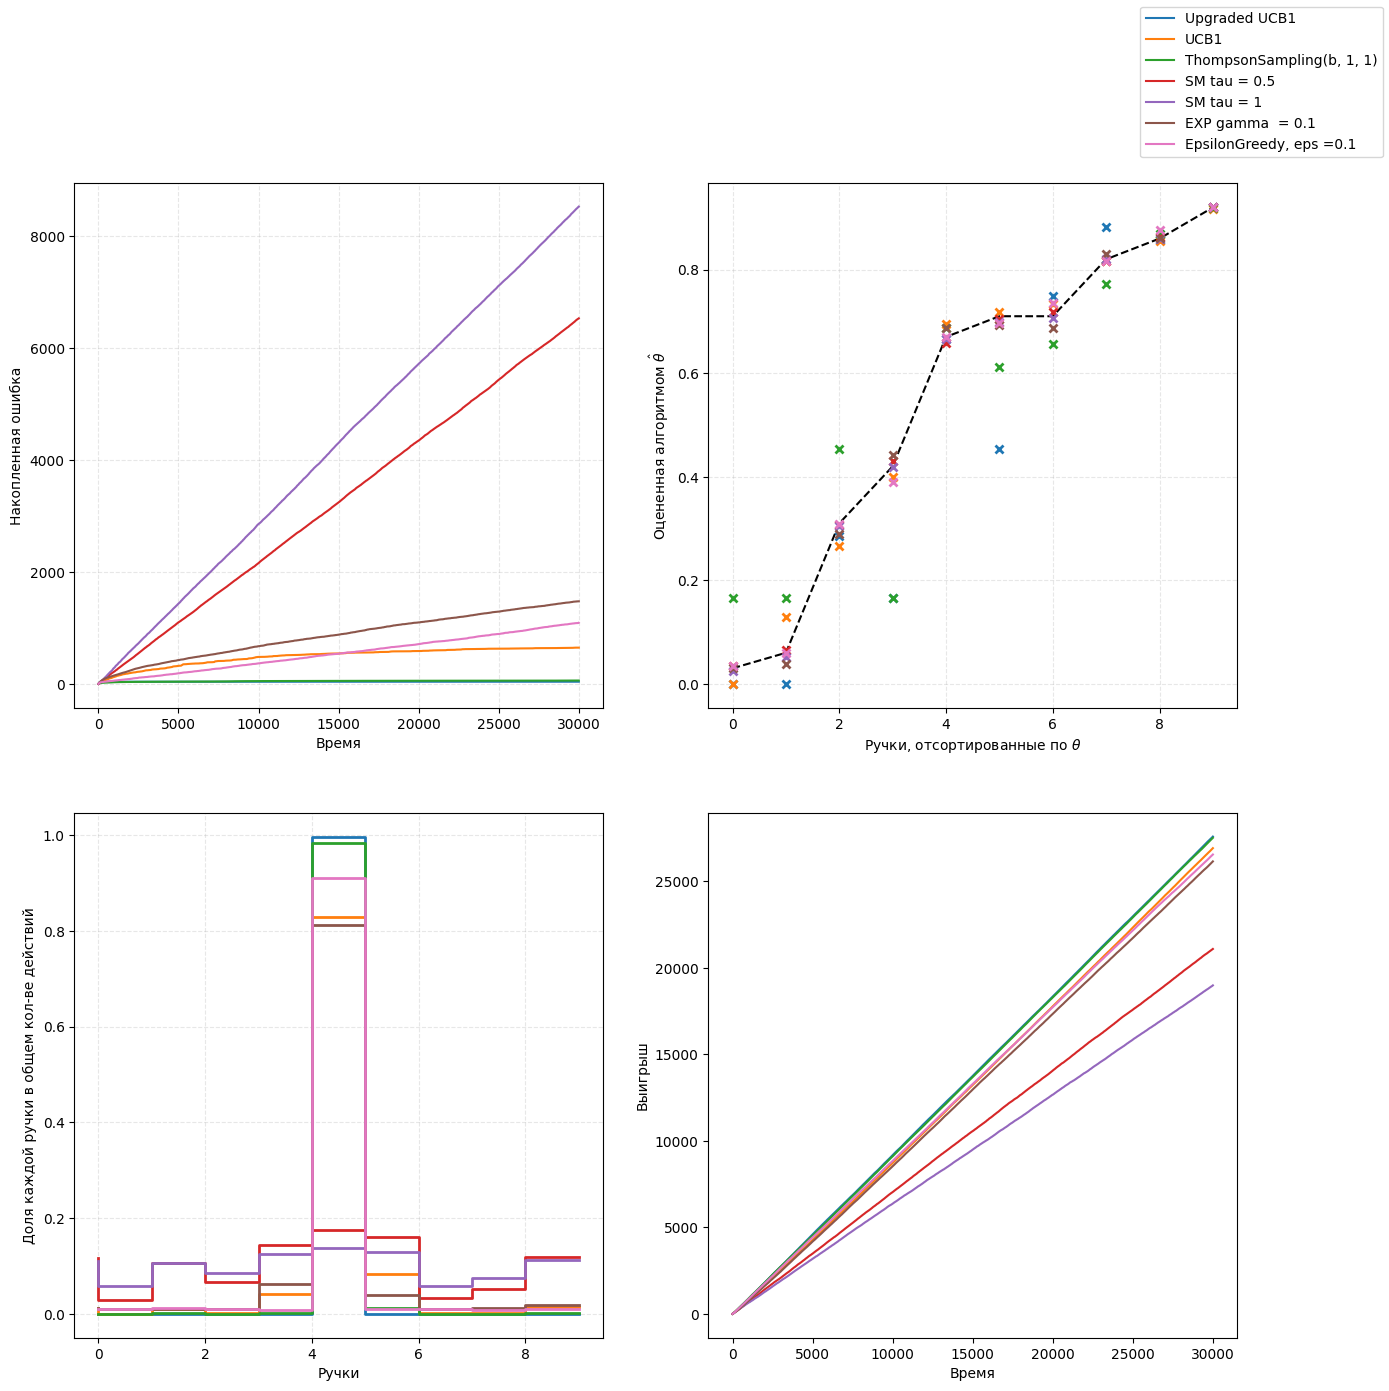

In [10]:
experiment(10, 30000)

# Задание про АБ


Вот вам функция для расчета размера выборки (тот противный вывод, который я показывал)
Вероятно для оценки размера выборки вы видели вот такую формулу.

$$n > \frac{\left[ \Phi^{-1} \left( 1-\alpha \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

Здесь $\varepsilon$ - размер эффекта, $\alpha$ - вероятность ошибки первого рода, $\beta$ - вероятность ошибки 2 рода

<img src = "https://alexanderdyakonov.files.wordpress.com/2019/05/d0b01.jpg?w=700">


Вспомните, какие там предположения были

In [37]:
from  scipy.stats import norm

In [35]:
def compute_sample_size_abs(epsilon, std1, std2, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (std1 ** 2 + std2 ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

Представим, что у вас есть данные АБ-теста [следующего](https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-cosmetics-shop) вида

Я их скачал и посчитал по дням разные виды событий
    

In [50]:
import pandas as pd
import duckdb
import hashlib
from sklearn.ensemble import IsolationForest

In [13]:
df = pd.read_csv('./hw4_data/2019-Dec.csv')

In [14]:
df.head(1)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc


In [15]:
df.event_type.unique()

array(['remove_from_cart', 'view', 'cart', 'purchase'], dtype=object)

In [ ]:
model = IsolationForest(contamination=0.05, random_state=42)  # contamination = % аномалий

# Обучение модели на данных
df['anomaly_score'] = model.fit_predict(df[['feature1', 'feature2']])

In [16]:
q = '''
select CAST(event_time as date) as dt,
    count(distinct user_id) as users,
    count(distinct user_session) as user_sessions,
    sum(case when event_type = 'cart' then 1 else 0 end) as add_to_cart,
    sum(case when event_type = 'view' then 1 else 0 end) as view,
    sum(case when event_type = 'purchase' then 1 else 0 end) as purchase
from df
group by 1
order by 1
'''
meta_df =  duckdb.query(q).to_df()


In [17]:
meta_df.head(5)

,dt,users,user_sessions,add_to_cart,view,purchase
0,2019-12-01,17540,29616,34525.0,59528.0,7236.0
1,2019-12-02,19391,31948,36202.0,64921.0,9079.0
2,2019-12-03,18735,30841,38986.0,63503.0,8217.0
3,2019-12-04,18836,30422,37450.0,65472.0,8371.0
4,2019-12-05,18183,29983,33650.0,61445.0,7767.0


Допустим, сейчас 15ое число и вам доступны только данные за 1-14. Вы хотите спланировать АБ-тест длительностью в 2 недели и проверить необходимых размер выборки, чтобы на горизонте в 2 недели уметь замечать изменения масштабом в 4% в показателях:

* Среднее кол-во сессий на пользователя за 2 недели
* Среднее кол-во заказов на сессию за 2 недели
* Среднее кол-во добавлений в корзину на пользователя за за 2 недели

Заметьте, что в подобном тесте единицей рандомизации является ПОЛЬЗОВАТЕЛЬ (а значит события типа "кол-во заказов на сессию" - не независимая выборка)

Проверьте, какой размер выборки вам подскажет "точная формула", которую мы вывели в прошлый раз и насколько это отличается от результата, который вы бы получили:

* бутстрепом

* Линеаризацией ratio + t-тестом

Линеаризация [раз](https://www.researchgate.net/publication/322969314_Consistent_Transformation_of_Ratio_Metrics_for_Efficient_Online_Controlled_Experiments), Линеаризация [два](https://habr.com/ru/companies/kuper/articles/768826/)


- А кааааак мне Монтееее-Кааааааааарлооооооо сдееееелать с эээээтим бутстрееееееепом твоиииииииииииим?

- а вот [так](https://habr.com/ru/articles/780932/)

In [18]:
meta_df["users"].describe()

count       24.000000
mean     17741.625000
std       1862.914262
min      11361.000000
25%      16775.250000
50%      18085.500000
75%      18885.500000
max      20128.000000
Name: users, dtype: float64

In [19]:
17741*7

124187

In [20]:
cart_counts = df[df['event_type'] == 'cart'].groupby(['user_id', 'event_type']).size().reset_index(name='count')
cart_counts['count'] = cart_counts['count']
cart_counts.head(5)

,user_id,event_type,count
0,2963072,cart,7
1,4661182,cart,2
2,8194617,cart,3
3,9794320,cart,1
4,12055855,cart,10


In [21]:
n_users = df['user_id'].nunique() # всего уникальных пользователей
n_users

302822

In [22]:
cart_counts.nunique()

user_id       70643
event_type        1
count           277
dtype: int64

In [46]:
stats = np.array(cart_counts["count"])
res = np.append(stats, np.zeros(302822-70643))
std = np.std(res)
mean = np.mean(res)
mean
variance

12.427739267138922

In [47]:
compute_sample_size_abs(mean*0.04,std,std )

227000

In [26]:
sessions_per_user = df.groupby('user_id')['user_session'].nunique()

In [48]:
stats = sessions_per_user.describe()
stats

count    302822.000000
mean          2.259733
std          12.343294
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        5362.000000
Name: user_session, dtype: float64

In [49]:
compute_sample_size_abs(stats["mean"]*0.04,stats["std"],stats["std"] )

292729

In [38]:
orders_per_session = df[df['event_type'] == 'purchase'].groupby('user_session').size().mean()
print("Среднее количество заказов на сессию для всего датасета:", orders_per_session)
session_orders = df[df['event_type'] == 'purchase'].groupby('user_session').size()

n_iterations = 20000
poisson_bootstrap_means = []

session_ids = session_orders.index.values

for _ in range(n_iterations):
    poisson_weights = np.random.poisson(1, len(session_ids))
    bootstrap_sample = session_orders * poisson_weights 
    orders_per_session_bootstrap = bootstrap_sample.sum() / (poisson_weights > 0).sum()
    poisson_bootstrap_means.append(orders_per_session_bootstrap)
    
bootstrap_mean = np.mean(poisson_bootstrap_means)
bootstrap_variance = np.var(poisson_bootstrap_means)

print("Среднее значение метрики из распределения Пуассоновского бутстрэпа:", bootstrap_mean)
print("Дисперсия метрики из распределения Пуассоновского бутстрэпа:", bootstrap_variance)


Среднее количество заказов на сессию для всего датасета: 7.5276648693488175
Среднее значение метрики из распределения Пуассоновского бутстрэпа: 11.908776787172213
Дисперсия метрики из распределения Пуассоновского бутстрэпа: 0.010162938557526277


In [39]:
compute_sample_size_abs(bootstrap_mean*0.04,bootstrap_variance, bootstrap_variance )

1